In [1]:
using VCFTools
using Plots
using DelimitedFiles
using Statistics

## HRC

In [18]:
# maf = lower than 0.0005
function compute_error_superlow(maf::AbstractVector, Xtrue::AbstractMatrix, Xtest::AbstractMatrix)
    n, p = size(Xtrue)
    counter = 0
    err = 0.0
    for i in 1:p
        if maf[i] ≤ 0.0005
            err += sum(@view(Xtrue[:, i]) .!= @view(Xtest[:, i]))
            counter += 1
        end
    end
    return err / n / counter
end

# maf = 0.0005-0.005
function compute_error_low(maf::AbstractVector, Xtrue::AbstractMatrix, Xtest::AbstractMatrix)
    n, p = size(Xtrue)
    counter = 0
    err = 0.0
    for i in 1:p
        if 0.001 ≤ maf[i] ≤ 0.005
            err += sum(@view(Xtrue[:, i]) .!= @view(Xtest[:, i]))
            counter += 1
        end
    end
    return err / n / counter
end
    
# maf = 0.005-0.05
function compute_error_medium(maf::AbstractVector, Xtrue::AbstractMatrix, Xtest::AbstractMatrix)
    n, p = size(Xtrue)
    min_maf = 0.005
    max_maf = 0.05
    counter = 0
    err = 0.0
    for i in 1:p
        if min_maf < maf[i] ≤ max_maf
            err += sum(@view(Xtrue[:, i]) .!= @view(Xtest[:, i]))
            counter += 1
        end
    end
    return err / n / counter
end

# maf = 0.05-0.5
function compute_error_high(maf::AbstractVector, Xtrue::AbstractMatrix, Xtest::AbstractMatrix)
    n, p = size(Xtrue)
    min_maf = 0.05
    counter = 0
    err = 0.0
    for i in 1:p
        if min_maf < maf[i]
            err += sum(@view(Xtrue[:, i]) .!= @view(Xtest[:, i]))
            counter += 1
        end
    end
    return err / n / counter
end

function findrange(maf::Float64, maf_ranges)
    result = 1
    for i in 2:length(maf_ranges)
        maf_ranges[i - 1] ≤ maf < maf_ranges[i] ? break : (result += 1)
    end
    return result
end

function compute_r2(
    mafs::AbstractVector,
    maf_min::Float64,
    maf_max::Float64,
    Xtrue::AbstractMatrix,
    Xtest::AbstractMatrix;
    verbose=false
    )
    mean_r2 = 0.0
    counter = 0
    for i in findall(x -> maf_min < x < maf_max, mafs)
        r2 = cor(Xtrue[:, i], Xtest[:, i])^2
#         x = @view(Xtrue[:, i])
#         y = @view(Xtest[:, i])
#         r2 = cov(x, y)^2 / var(x) / var(y)
        if !isnan(r2)
            verbose && println("snp = $i, r2 = $r2")
            mean_r2 += r2
            counter += 1
        end
    end
    return mean_r2 / counter
end

function compute_r2_by_maf(mafs::AbstractVector, Xtrue::AbstractMatrix, Xtest::AbstractMatrix)
    maf_ranges = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
    r2 = zeros(length(maf_ranges) - 1)
    for i in 1:(length(maf_ranges)-1)
        r2[i] = compute_r2(mafs, maf_ranges[i], maf_ranges[i + 1], Xtrue, Xtest)
    end
    return r2, maf_ranges
end

compute_r2_by_maf (generic function with 1 method)

In [ ]:
1.910949742021785e-5

In [ ]:
0.00001

In [21]:
mean_r2 = 0.0
counter = 0
for i in findall(x -> x == 2, mafs .* 2 * 26165)
    r2 = cor(Xtrue[:, i], Xbeagle[:, i])^2
    if !isnan(r2)
        println("snp = $i, r2 = $r2")
        mean_r2 += r2
        counter += 1
    end
end
mean_r2 / counter

snp = 2007, r2 = 1.0019938750147354e-6
snp = 2602, r2 = 1.3879522862526301e-6
snp = 4084, r2 = 1.939296493196486e-6
snp = 6574, r2 = 0.999996612102676
snp = 11790, r2 = 0.9615252728211884
snp = 12361, r2 = 0.9999938233115251
snp = 16388, r2 = 0.9999874239460438
snp = 16506, r2 = 1.0019961373055463e-6
snp = 17790, r2 = 0.9999966121026758
snp = 18265, r2 = 1.0561592807186823e-6
snp = 19017, r2 = 1.0020024863700168e-6
snp = 20228, r2 = 0.9999907650743741
snp = 21085, r2 = 0.9999837518636723
snp = 21687, r2 = 0.4994987907173742
snp = 21837, r2 = 1.0
snp = 24071, r2 = 0.9999947493206628
snp = 25366, r2 = 0.9999873642832404
snp = 27559, r2 = 0.31902504813514276
snp = 29860, r2 = 0.9999977457181176
snp = 31659, r2 = 1.0
snp = 32312, r2 = 1.0
snp = 32675, r2 = 1.0020028933077767e-6
snp = 33805, r2 = 0.9995981204044722
snp = 34238, r2 = 0.9987494208303043
snp = 43448, r2 = 0.9833810485959528
snp = 43629, r2 = 0.9999987600077962
snp = 45155, r2 = 0.7027066278952764
snp = 49875, r2 = 0.9999849899

0.5422997054728315

## Chromosome 20

In [6]:
chr = 20
truth  = "target.chr$chr.full.vcf.gz"
mendel = "mendel.imputed.chr$chr.vcf.gz"
beagle = "beagle.chr$chr.imputed.vcf.gz"
mmac4  = "minimac4.chr$chr.result.dose.vcf.gz"

isfile(truth) && isfile(mendel) && isfile(beagle) && isfile(mmac4) || error("file doens't exist!")

Xtrue = convert_gt(UInt8, truth, msg="importing Xtrue")
Xmendel = convert_gt(UInt8, mendel, msg="importing Xmendel")
Xbeagle = convert_ds(Float32, beagle, msg="importing Xbeagle")
Xmmac4 = convert_ds(Float32, mmac4, msg="importing Xmmac")
n, p = size(Xtrue)

# need to import each chunk of impute5 result separately
chunks = chr == 20 ? 4 : 14
Ximp5 = Vector{Matrix{Float32}}(undef, chunks)
for i in 1:chunks
    Ximp5[i] = convert_ds(Float32, "impute5.chr$chr.result.chunk$i.vcf.gz", msg="importing Ximp5 $i / $chunks")
end
Ximp5 = hcat(Ximp5...);

importing Xtrue100%|████████████████████████████████████| Time: 0:01:47
importing Xmendel100%|██████████████████████████████████| Time: 0:01:27
importing Xbeagle100%|██████████████████████████████████| Time: 0:04:32
importing Xmmac100%|████████████████████████████████████| Time: 0:04:35
importing Ximp5 1 / 4100%|██████████████████████████████| Time: 0:01:30
importing Ximp5 2 / 4100%|██████████████████████████████| Time: 0:01:10
importing Ximp5 3 / 4100%|██████████████████████████████| Time: 0:01:32
importing Ximp5 4 / 4100%|██████████████████████████████| Time: 0:00:15


1000×882742 Matrix{Float32}:
 0.0    0.0    0.0  0.0    0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.18
 0.0    0.0    0.0  0.0    0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.768
 0.0    0.0    0.0  0.501  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.096
 0.001  0.001  0.0  0.001  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0    0.0    0.0  0.0    0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.633
 0.0    0.0    0.0  0.0    0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0    0.0    0.0  0.0    0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.024
 0.0    0.0    0.0  0.0    0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0    0.0  0.0    0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.766
 0.0    0.0    0.0  0.0    0.0  2.0     0.0  0.0  0.0  0.0  0.0  0.0  1.998
 0.0    0.0    0.0  0.0    0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  1.247
 0.0    0.0    0.0  0.0    0.0  2.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0    0.0  0.0    0.0  2.0     0.0  0.0  0.0  0.0  0.0  0.0

In [12]:
findfirst(!iszero, sort(mafs))

20573

In [13]:
sort(mafs)[20573]

1.910949742021785e-5

In [17]:
findall(x -> x < 0.00005, mafs)

32522-element Vector{Int64}:
     49
    109
    116
    199
    222
    238
    300
    308
    327
    330
    341
    346
    350
      ⋮
 882367
 882437
 882441
 882470
 882532
 882533
 882545
 882579
 882632
 882634
 882735
 882737

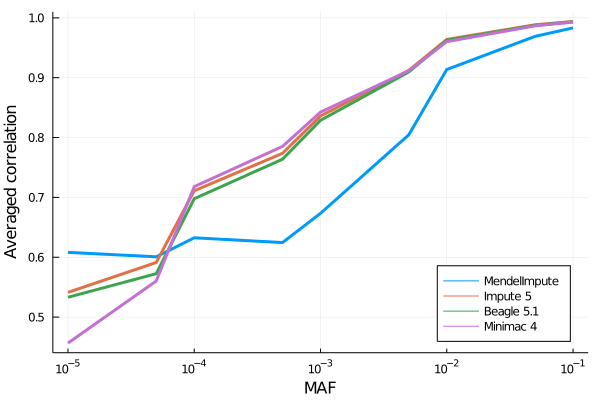

In [22]:
chr = 20
mafs = vec(readdlm("chr$chr.maf"))

r2_mendel, maf_ranges = compute_r2_by_maf(mafs, Xtrue, Xmendel)
r2_impute5, maf_ranges = compute_r2_by_maf(mafs, Xtrue, Ximp5)
r2_beagle5, maf_ranges = compute_r2_by_maf(mafs, Xtrue, Xbeagle)
r2_mimimac4, maf_ranges = compute_r2_by_maf(mafs, Xtrue, Xmmac4)

chr20_plt = plot(maf_ranges[1:end-1], r2_mendel, label="MendelImpute", legend=:bottomright, lw = 3,
    xlabel="MAF", ylabel="Averaged correlation", xaxis=:log)
plot!(chr20_plt, maf_ranges[1:end-1], r2_impute5, label="Impute 5", lw = 3)
plot!(chr20_plt, maf_ranges[1:end-1], r2_beagle5, label="Beagle 5.1", lw = 3)
plot!(chr20_plt, maf_ranges[1:end-1], r2_mimimac4, label="Minimac 4", lw = 3)

In [95]:
chr = 20
truth  = "target.chr$chr.full.vcf.gz"
mendel = "mendel.imputed.chr$chr.vcf.gz"
beagle = "beagle.imputed.chr$chr.vcf.gz"
mmac4  = "minimac4.chr$chr.result.dose.vcf.gz"

isfile(truth) && isfile(mendel) && isfile(beagle) && isfile(mmac4) || error("file doens't exist!")

Xtrue = convert_gt(UInt8, truth, msg="importing Xtrue")
Xmendel = convert_gt(UInt8, mendel, msg="importing Xmendel")
Xbeagle = convert_gt(UInt8, beagle, msg="importing Xbeagle")
Xmmac4 = convert_gt(UInt8, mmac4, msg="importing Xmmac")
n, p = size(Xtrue)

# need to import each chunk of impute5 result separately
chunks = chr == 20 ? 3 : 7
Ximp5 = Vector{Matrix{UInt8}}(undef, chunks)
for i in 1:chunks
    Ximp5[i] = convert_gt(UInt8, "impute5.chr$chr.result.chunk$i.vcf.gz", msg="importing Ximp5 $i / $chunks")
end
Ximp5 = hcat(Ximp5...)

println("error mendel = $(sum(Xmendel .!= Xtrue) / n / p)")
println("error beagle = $(sum(Xbeagle .!= Xtrue) / n / p)")
println("error minimac4 = $(sum(Xmmac4 .!= Xtrue) / n / p)")
println("error impute5 = $(sum(Ximp5 .!= Xtrue) / n / p)")

importing Xtrue100%|████████████████████████████████████| Time: 0:00:09
importing Xmendel100%|██████████████████████████████████| Time: 0:00:09
importing Xbeagle100%|██████████████████████████████████| Time: 0:00:10
importing Xmmac100%|████████████████████████████████████| Time: 0:00:11


error mendel = 0.007625939010756925
error beagle = 0.004633910807224618
error minimac4 = 0.004582820263676758
error impute5 = 0.004575148473030074


In [96]:
@show compute_error_superlow(mafs, Xtrue, Xmendel)
@show compute_error_superlow(mafs, Xtrue, Ximp5)
@show compute_error_superlow(mafs, Xtrue, Xbeagle)
@show compute_error_superlow(mafs, Xtrue, Xmmac4);

compute_error_superlow(mafs, Xtrue, Xmendel) = 0.003333333333333333
compute_error_superlow(mafs, Xtrue, Ximp5) = 0.0022222222222222222
compute_error_superlow(mafs, Xtrue, Xbeagle) = 0.0019444444444444446
compute_error_superlow(mafs, Xtrue, Xmmac4) = 0.0016666666666666666


In [97]:
@show compute_error_low(mafs, Xtrue, Xmendel)
@show compute_error_low(mafs, Xtrue, Ximp5)
@show compute_error_low(mafs, Xtrue, Xbeagle)
@show compute_error_low(mafs, Xtrue, Xmmac4);

compute_error_low(mafs, Xtrue, Xmendel) = 0.007592807901863491
compute_error_low(mafs, Xtrue, Ximp5) = 0.004540745325171985
compute_error_low(mafs, Xtrue, Xbeagle) = 0.004608323286671509
compute_error_low(mafs, Xtrue, Xmmac4) = 0.004552014281165818


In [98]:
@show compute_error_medium(mafs, Xtrue, Xmendel)
@show compute_error_medium(mafs, Xtrue, Ximp5)
@show compute_error_medium(mafs, Xtrue, Xbeagle)
@show compute_error_medium(mafs, Xtrue, Xmmac4);

compute_error_medium(mafs, Xtrue, Xmendel) = 0.007691647667377607
compute_error_medium(mafs, Xtrue, Ximp5) = 0.0046297467578632545
compute_error_medium(mafs, Xtrue, Xbeagle) = 0.004681669976220245
compute_error_medium(mafs, Xtrue, Xmmac4) = 0.004639650903385551


In [99]:
@show compute_error_high(mafs, Xtrue, Xmendel)
@show compute_error_high(mafs, Xtrue, Ximp5)
@show compute_error_high(mafs, Xtrue, Xbeagle)
@show compute_error_high(mafs, Xtrue, Xmmac4);

compute_error_high(mafs, Xtrue, Xmendel) = 0.007594025118339536
compute_error_high(mafs, Xtrue, Ximp5) = 0.004562734008702594
compute_error_high(mafs, Xtrue, Xbeagle) = 0.004612430992028244
compute_error_high(mafs, Xtrue, Xmmac4) = 0.0045613847693362864


## Chromosome 10

In [84]:
chr = 10
truth  = "target.chr$chr.full.vcf.gz"
mendel = "mendel.imputed.chr$chr.vcf.gz"
beagle = "beagle.imputed.chr$chr.vcf.gz"
mmac4  = "minimac4.chr$chr.result.dose.vcf.gz"

isfile(truth) && isfile(mendel) && isfile(beagle) && isfile(mmac4) || error("file doens't exist!")

Xtrue = convert_gt(UInt8, truth, msg="importing Xtrue")
Xmendel = convert_gt(UInt8, mendel, msg="importing Xmendel")
Xbeagle = convert_gt(UInt8, beagle, msg="importing Xbeagle")
Xmmac4 = convert_gt(UInt8, mmac4, msg="importing Xmmac")
n, p = size(Xtrue)

# need to import each chunk of impute5 result separately
chunks = chr == 20 ? 3 : 7
Ximp5 = Vector{Matrix{UInt8}}(undef, chunks)
for i in 1:chunks
    Ximp5[i] = convert_gt(UInt8, "impute5.chr$chr.result.chunk$i.vcf.gz", msg="importing Ximp5 $i / $chunks")
end
Ximp5 = hcat(Ximp5...)

println("error mendel = $(sum(Xmendel .!= Xtrue) / n / p)")
println("error beagle = $(sum(Xbeagle .!= Xtrue) / n / p)")
println("error minimac4 = $(sum(Xmmac4 .!= Xtrue) / n / p)")
println("error impute5 = $(sum(Ximp5 .!= Xtrue) / n / p)")

importing Xtrue100%|████████████████████████████████████| Time: 0:00:14
importing Xmendel100%|██████████████████████████████████| Time: 0:00:14
importing Xbeagle100%|██████████████████████████████████| Time: 0:00:16
importing Xmmac100%|████████████████████████████████████| Time: 0:00:25
importing Ximp5 1 / 7100%|██████████████████████████████| Time: 0:00:07
importing Ximp5 4 / 7100%|██████████████████████████████| Time: 0:00:06


error mendel = 0.00755579594361687
error beagle = 0.004842511636215674
error minimac4 = 0.004917863369159976
error impute5 = 0.004826103496984674


In [87]:
chr = 10
mafs = vec(readdlm("chr$chr.maf"));

In [93]:
@show compute_error_superlow(mafs, Xtrue, Xmendel)
@show compute_error_superlow(mafs, Xtrue, Ximp5)
@show compute_error_superlow(mafs, Xtrue, Xbeagle)
@show compute_error_superlow(mafs, Xtrue, Xmmac4);

compute_error_superlow(mafs, Xtrue, Xmendel) = 0.016984126984126983
compute_error_superlow(mafs, Xtrue, Ximp5) = 0.014126984126984127
compute_error_superlow(mafs, Xtrue, Xbeagle) = 0.015238095238095238
compute_error_superlow(mafs, Xtrue, Xmmac4) = 0.014444444444444446


In [89]:
@show compute_error_low(mafs, Xtrue, Xmendel)
@show compute_error_low(mafs, Xtrue, Ximp5)
@show compute_error_low(mafs, Xtrue, Xbeagle)
@show compute_error_low(mafs, Xtrue, Xmmac4);

compute_error_low(mafs, Xtrue, Xmendel) = 0.002436883607666572
compute_error_low(mafs, Xtrue, Ximp5) = 0.0013853023070183371
compute_error_low(mafs, Xtrue, Xbeagle) = 0.0013599060854273394
compute_error_low(mafs, Xtrue, Xmmac4) = 0.0013273540223935744


In [90]:
@show compute_error_medium(mafs, Xtrue, Xmendel)
@show compute_error_medium(mafs, Xtrue, Ximp5)
@show compute_error_medium(mafs, Xtrue, Xbeagle)
@show compute_error_medium(mafs, Xtrue, Xmmac4);

compute_error_medium(mafs, Xtrue, Xmendel) = 0.004799264231937946
compute_error_medium(mafs, Xtrue, Ximp5) = 0.0025439465756968527
compute_error_medium(mafs, Xtrue, Xbeagle) = 0.002577029829738535
compute_error_medium(mafs, Xtrue, Xmmac4) = 0.002534979676490062


In [91]:
@show compute_error_high(mafs, Xtrue, Xmendel)
@show compute_error_high(mafs, Xtrue, Ximp5)
@show compute_error_high(mafs, Xtrue, Xbeagle)
@show compute_error_high(mafs, Xtrue, Xmmac4);

compute_error_high(mafs, Xtrue, Xmendel) = 0.01914992585457357
compute_error_high(mafs, Xtrue, Ximp5) = 0.013095780681630946
compute_error_high(mafs, Xtrue, Xbeagle) = 0.013151294693215377
compute_error_high(mafs, Xtrue, Xmmac4) = 0.013550716739122167


In [29]:
chr = 10
mafs = vec(readdlm("chr$chr.maf"))
maf_ranges, r2 = compute_r2_by_maf(mafs, Xtrue, Xbeagle)

(0.00041597337770382697:0.005046303299215113:0.5, [0.9658385148274495, 0.9659965740507426, 0.9653693402083796, 0.963537219755768, 0.9647530344357451, 0.964270110402712, 0.9679371195958859, 0.9682478276519988, 0.9660785909015133, 0.9711307212169902  …  0.9687328899126063, 0.9646378401996296, 0.9624545853647755, 0.9728823427567521, 0.9635352641844053, 0.9658650735316509, 0.9600783875303173, 0.9650103042569805, 0.9688421520496872, 0.9782145539591008])